In [1]:
pip install git+https://github.com/logictensornetworks/logictensornetworks.git

  Cloning https://github.com/logictensornetworks/logictensornetworks.git to /tmp/pip-req-build-q174jigp
  Running command git clone --filter=blob:none --quiet https://github.com/logictensornetworks/logictensornetworks.git /tmp/pip-req-build-q174jigp
  Resolved https://github.com/logictensornetworks/logictensornetworks.git to commit f3027f32fb45ce880fd5536f9dc0592da01fe5c9
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for ltn: filename=ltn-2.1-py3-none-any.whl size=13096 sha256=87f502ed6b3ec33badbd148c05f6fa338cf65409c9b26eebe1ace5951f62b6d6
  Stored in directory: /tmp/pip-ephem-wheel-cache-cq2g_4qb/wheels/a9/a8/78/c522f701d2dfbbfc3e4a022fa6eedc991909f068ae99c97586
Successfully built ltn


In [2]:
!pip install --upgrade git+https://github.com/logictensornetworks/logictensornetworks.git

  Cloning https://github.com/logictensornetworks/logictensornetworks.git to /tmp/pip-req-build-o9tpymru
  Running command git clone --filter=blob:none --quiet https://github.com/logictensornetworks/logictensornetworks.git /tmp/pip-req-build-o9tpymru
  Resolved https://github.com/logictensornetworks/logictensornetworks.git to commit f3027f32fb45ce880fd5536f9dc0592da01fe5c9
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
import ltn
print(dir(ltn))


['Constant', 'Function', 'Predicate', 'Proposition', 'Variable', 'Wrapper_Connective', 'Wrapper_Formula_Aggregator', 'Wrapper_Quantifier', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'as_tensors', 'core', 'diag', 'diag_lock', 'fuzzy_ops', 'undiag', 'utils']


In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import ltn
import tensorflow as tf

In [5]:
# Load the dataset
feeds_df = pd.read_csv("feeds2.csv")

In [6]:
print(feeds_df.columns)


Index(['temperature', 'humidity', 'vibration', 'rotational_speed',
       'air_temperature'],
      dtype='object')


In [7]:
# Data preprocessing
feeds_df.dropna(inplace=True)
feeds_df['rotational_speed'] = feeds_df['rotational_speed'].apply(lambda x: min(x, 250))  # Scaling rotational speed
feeds_df['air_temperature'] = (feeds_df['air_temperature'] - feeds_df['air_temperature'].min()) / \
                              (feeds_df['air_temperature'].max() - feeds_df['air_temperature'].min()) * 50  # Scaling air temperature up to 50
X = feeds_df[['temperature', 'humidity', 'vibration', 'rotational_speed', 'air_temperature']]

In [8]:
# Symbolic Injection (Defining domain knowledge rules)
def rule_vibration(vibration):
    return vibration < 1  # Stricter threshold for bad motor

def rule_temperature(temperature):
    return temperature < 65  # Lower the threshold to classify as good


In [9]:
# Apply rules to dataset
feeds_df['rule_vibration'] = feeds_df['vibration'].apply(rule_vibration)
feeds_df['rule_temperature'] = feeds_df['temperature'].apply(rule_temperature)

In [10]:
# Combine rules to create labels
y = (feeds_df['rule_vibration'] & feeds_df['rule_temperature']).astype(int)  # Convert to binary labels

In [11]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# LTN adaptation
motor_good = ltn.Predicate(
    tf.keras.Sequential([
        tf.keras.layers.Dense(10, activation="relu", input_shape=(1,)),
        tf.keras.layers.Dense(1, activation="sigmoid")
    ])
)

vib = ltn.Variable("vib", X[['vibration']].values)
temp = ltn.Variable("temp", X[['temperature']].values)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
import ltn

# Check available attributes within ltn.fuzzy_ops
print(dir(ltn.fuzzy_ops))

['Aggreg_LogProd', 'Aggreg_Max', 'Aggreg_Mean', 'Aggreg_Min', 'Aggreg_Prod', 'Aggreg_SumLog', 'Aggreg_pMean', 'Aggreg_pMeanError', 'And_Luk', 'And_Min', 'And_Prod', 'Equiv', 'Implies_Godel', 'Implies_Goguen', 'Implies_KleeneDienes', 'Implies_Luk', 'Implies_Reichenbach', 'Not_Godel', 'Not_Std', 'Or_Luk', 'Or_Max', 'Or_ProbSum', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'eps', 'not_ones', 'not_zeros', 'tf', 'warn']


In [14]:
import ltn
import tensorflow as tf
import numpy as np

# ... (other function definitions)

from ltn.core import Formula  # Import Formula from ltn.core

# Define a custom function to apply Implies_Reichenbach
def apply_implies(operand1, operand2):
    # Cast operands to float tensors for compatibility
    operand1_tensor = tf.cast(operand1.tensor, tf.float32)
    operand2_tensor = tf.cast(operand2.tensor, tf.float32)

    # Apply Implies_Reichenbach to the tensors
    result_tensor = ltn.fuzzy_ops.Implies_Reichenbach()(operand1_tensor, operand2_tensor)

    # Create a new Formula from the result tensor
    # Using set union for free_vars:
    result_formula = Formula(result_tensor, free_vars=set(operand1.free_vars).union(set(operand2.free_vars)))

    return result_formula

# Custom function to apply And_Min to a list of formulas
def apply_and_min(formulas):
    result = formulas[0].tensor  # Initialize with the tensor of the first formula
    for formula in formulas[1:]:
        # Apply And_Min to the tensors of the formulas
        result = ltn.fuzzy_ops.And_Min()(result, formula.tensor) # Applying the fix
    # Wrap the final result back into a Formula object
    # Applying the fix: Access the free_vars from the original result
    result_formula = Formula(result, free_vars=formulas[0].free_vars)
    return result_formula


def custom_aggregator(formula):
    return tf.reduce_mean(formula.tensor)

# Create an LTN Variable for humidity
humidity = ltn.Variable("humidity", X[['humidity']].values) # Define humidity similar to vib and temp

# Construct the formula using And_Min or And_Prod
formula_body = apply_and_min([
    apply_implies(motor_good(vib), motor_good(temp)),

])

# Apply custom aggregation
formula = custom_aggregator(formula_body)

In [15]:
# Train a machine learning model
clf = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', random_state=42)

In [16]:
# Predictions
y_pred = clf.predict(X_test)

In [17]:
# Evaluation
conf_mat = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_mat)
print("Classification Report:\n", classification_report(y_test, y_pred))

Confusion Matrix:
 [[ 8  0]
 [ 0 32]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00        32

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



(40, 5, 2)


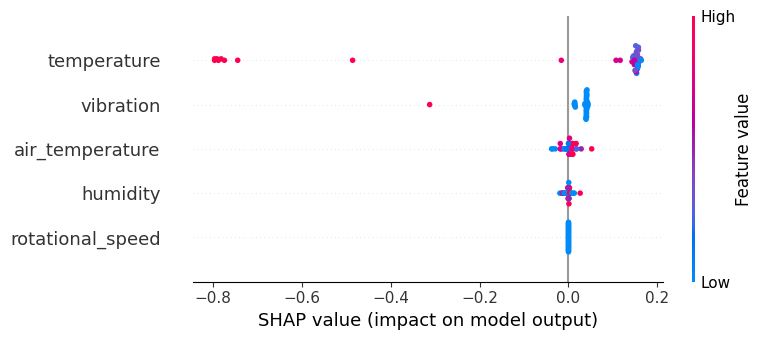

In [18]:
explainer = shap.Explainer(clf, X_train)
shap_values = explainer(X_test[:200])  # Ensure full dataset is used
print(shap_values.shape)  # Check the shape, it should be (number_of_samples, number_of_features)

# Assuming your target variable has two classes, you might need to specify the class index:
shap.summary_plot(shap_values.values[:,:,1], X_test[:200], feature_names=X_test.columns) # if you want to plot for class 1
# or
# shap.summary_plot(shap_values.values[:,:,0], X_test[:200], feature_names=X_test.columns) # if you want to plot for class 0

In [19]:
# Function for making predictions
def predict_motor_status(temp, humidity, vib, speed, air_temp):
    test_input = np.array([[temp, humidity, vib, speed, air_temp]])
    prediction = clf.predict(test_input)
    return "Motor is GOOD" if prediction == 1 else "Motor is BAD"

In [20]:
# Example usage
print(predict_motor_status(30.4, 41, 0, 200, 30))  # Example of a GOOD motor
print(predict_motor_status(65, 41, 1, 250, 50))  # Example of a BAD motor

Motor is GOOD
Motor is BAD


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


temperature, humidity, vibartion, rotational_
speed, air_temperature

In [21]:
import joblib

# Train your model (you already did this)
clf = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=42)
clf.fit(X_train, y_train)

# Save the trained model to a file
joblib.dump(clf, "motor_health_model.pkl")


['motor_health_model.pkl']